In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
import h5py

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 50, 50

train_data_dir = 'data/symlinks/train'
validation_data_dir = 'data/symlinks/validation'
test_data_dir = 'data/symlinks/test'
nb_epoch = 1
batch_size=128

In [3]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        samplewise_center=True,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        samplewise_center=True,
        rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        follow_links=True)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        follow_links=True)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary',
        follow_links=True)

Found 87874 images belonging to 2 classes.
Found 72289 images belonging to 2 classes.
Found 48224 images belonging to 2 classes.


In [5]:
def get_model():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

model = get_model()

In [6]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

In [7]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples/batch_size,
        epochs=nb_epoch,
        validation_data=validation_generator,
        verbose=1,
        validation_steps=validation_generator.samples/batch_size,
        workers=8,
        pickle_safe=True,
        callbacks=[history, tensorboard, checkpointer])

Epoch 1/1
687/686 [==============================] - 44s - loss: 0.0852 - acc: 0.9722 - val_loss: 0.0324 - val_acc: 0.9903


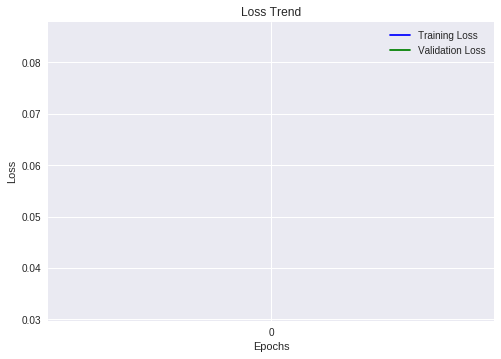

In [10]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()

plt.show()

In [11]:
test_loss, test_acc = model.evaluate_generator(
         test_generator,
         workers=8,
         pickle_safe=True,
         steps=test_generator.samples/batch_size)

print("test_loss: %.4f - test_acc: %.4f"%(test_loss, test_acc))

test_loss: 0.0442 - test_acc: 0.9867
